In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on
%matplotlib inline

In [2]:
import sqlite3
import re
import string
import numpy as np
import pandas as pd
import scipy.stats

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LassoLarsCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (accuracy_score, r2_score,
                             confusion_matrix, f1_score)
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update({'font.size': 18,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'ytick.alignment': 'center'
                     })

# Analysis of Pitchfork Media Album Reviews

This notebook contains my analysis of a dataset containing 18,393 Pitchfork album reviews taken from kaggle. Check the README for instructions on how to get the data.

## Business Understanding

In this analysis we will look at three questions. 

1. How can the genre of an album be predicted using the text of the review? This will allow us to understand how different genres relate to one another, and which genres are most similar to each other.

2. What words correlate with high score? Specifically, can we find a small set of words that contain most of the information about the score? Being able to judge the sentiment in a review will help with quickly identifying albums which have a better chance of being successful.

3. Is there such a thing as the 'sophomore slump'? In other words, is there a tendancy for the second album a band records to recieve a lower score than their debut? This is something believed by many people, so it is nice to see if there is data backing it up. This also helps us gauge the sucess of an album relative to its predecessors.

## Data Understanding
Here we can see some basic facts about the raw data. First, we look at the number of reviews in each genre we have selected. We also look the number of rows with duplicate IDs, which correspond to reviews with multiple genres. We will discuss how we assign a single category to each review below. We can also look at the average score. 

### Pull data out of sqlite database
Use the `get_data.sh` script to download the data. Test for duplicate entries, caused by reviews with more than one genre.

In [4]:
conn = sqlite3.connect('database.sqlite')

query = """
SELECT r.reviewid,
       r.title,
       r.artist,
       r.score,
       r.best_new_music,
       r.author,
       r.pub_date,
       c.content,
       g.genre
FROM reviews r
JOIN genres g ON g.reviewid = r.reviewid
JOIN content c ON c.reviewid = r.reviewid
WHERE g.genre IN ('rock', 'rap', 'experimental', 'pop/r&b', 'electronic')
ORDER BY pub_date;
"""

df = pd.read_sql(query, conn)
print('Number of reviews with each genre:')
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print('Number of duplicate ids: {}'.format(test_dups[test_dups != 1].shape[0]))
print()

print('Summary Statistics for review score:')
print(df['score'].describe())

Number of reviews with each genre:
rock            9442
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
Name: genre, dtype: int64
Number of duplicate ids: 3062

Summary Statistics for review score:
count    18122.000000
mean         6.969005
std          1.321750
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64


## Data Preparation
In this section we prepare the data by making sure each review has one and only one genre, as well as stemming and vectorizing the review text.

### Preparing Categorical Data: Disambiguating Genre
Although some of the reviews have no assigned genre, we have eliminated these by only looking at the top 5 genres. Some reviews have multiple genres, often 'rock' and a more specific genre. Thus we make sure that there is only one genre assigned to each review by assigning reviews with multiple genres to the more "specific" one, with fewer reviews in general. Then, we check explicitly that no reviews have dupicate entries.

In [5]:
genre_order = ['pop/r&b', 'rap', 'experimental', 'electronic', 'rock']
genre_type = pd.api.types.CategoricalDtype(genre_order, ordered=True)
df['genre'] = pd.Series(df['genre'], dtype=genre_type)

df = df.sort_values('genre').groupby('reviewid').first()
df = pd.DataFrame(df.to_records())
print('Number of reviews with each genre:')
print(df['genre'].value_counts())

test_dups = df['reviewid'].value_counts()
print('Number of duplicate ids: {}'.format(test_dups[test_dups != 1].shape[0]))

Number of reviews with each genre:
rock            6871
electronic      3379
experimental    1766
pop/r&b         1432
rap             1426
Name: genre, dtype: int64
Number of duplicate ids: 0


### Create the memorizing stemmer
Later, we will want to go back and see which words correspond to particular stems. This class stems the words with the snowball stemmer from NLTK, and then keeps track of which words got assigned to that stem, as well as how many times.

In [6]:
class MemorizingSnowballStemmer():
    """Stem words using the snowball stemmer, remembering
    which words were assigned to each stem."""

    def __init__(self, lang, **kwargs):
        """Pass arguments onto SnowballStemmer, and
        initialize the memory dictionary."""
        self._stemmer = SnowballStemmer(lang, **kwargs)
        self._mem = {}

    def stem(self, word):
        "Stem words using SnowballStemmer, and update the memory dictionary."
        stemmed_word = self._stemmer.stem(word)
        if stemmed_word in self._mem:
            if word not in self._mem[stemmed_word]:
                self._mem[stemmed_word][word] = 1
            else:
                self._mem[stemmed_word][word] += 1
        else:
            self._mem[stemmed_word] = {word: 1}
        return stemmed_word

    def unstem(self, stem):
        "Return all words assigned to a particular stem."
        if stem in self._mem:
            return self._mem[stem]
        else:
            return {}

    def unstem_most_common(self, stem):
        "Return the word most commonly assigned to a particular stem."
        if stem in self._mem:
            freq_dict = self._mem[stem]
            return sorted(freq_dict, key=freq_dict.get, reverse=True)[0]

### Stem the reviews using our memorizing stemmer

In [7]:
stemmer = MemorizingSnowballStemmer('english', ignore_stopwords=True)
strip_punct = str.maketrans('', '', string.punctuation)


def stem_text(s):
    "Stem each word in s, then join the stems together with spaces."
    return ' '.join(
        [stemmer.stem(word) for word in
         word_tokenize(s.translate(strip_punct))])


df['content_stemmed'] = df['content'].apply(stem_text)

### Vectorize the stemmed text
We will use the tfidf vectorization for PCA/SVM classification as well as L1 feature selection, and the count vectorization for Naive Bayes.

In [8]:
vect_tfidf = TfidfVectorizer(stop_words='english', min_df=5)
words_tfidf = vect_tfidf.fit_transform(df['content_stemmed'])
print(words_tfidf.shape)

(14874, 30862)


In [9]:
vect_count = CountVectorizer(stop_words='english', min_df=5)
words_count = vect_count.fit_transform(df['content_stemmed'])
print(words_count.shape)

(14874, 30862)


### Select target columns, and create testing and training data sets.

In [10]:
target_columns = ['score', 'best_new_music', 'genre']
targets = df[target_columns]
words_tfidf_train, words_tfidf_test, \
    words_count_train, words_count_test, \
    targets_train, targets_test \
    = train_test_split(words_tfidf, words_count, targets, random_state=420)

## Data Modeling: Predicting Genre From Text Features With PCA

### Classify the data with PCA and a Linear SVC.

In [10]:
pca = PCA(n_components=10)
pca_features = pca.fit_transform(words_tfidf_train.toarray())

clf_svm = LinearSVC()
clf_svm.fit(pca_features, targets_train['genre'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Results Evaluation: Predicting Genre From Text Features With PCA

### Plots of PCA/SVC data.
In the plots, we can see that reviews of Rap albums are well seperated from the other groups, but the rest are not really seperable. For clarity, R&B and Experimental albums are not shown, but they are mixed with the Electronic and Rock albums. A trend in score is not really visible either.

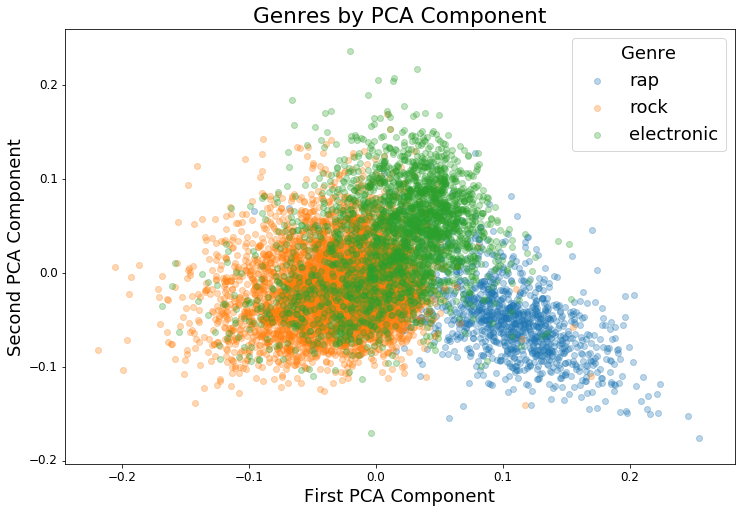

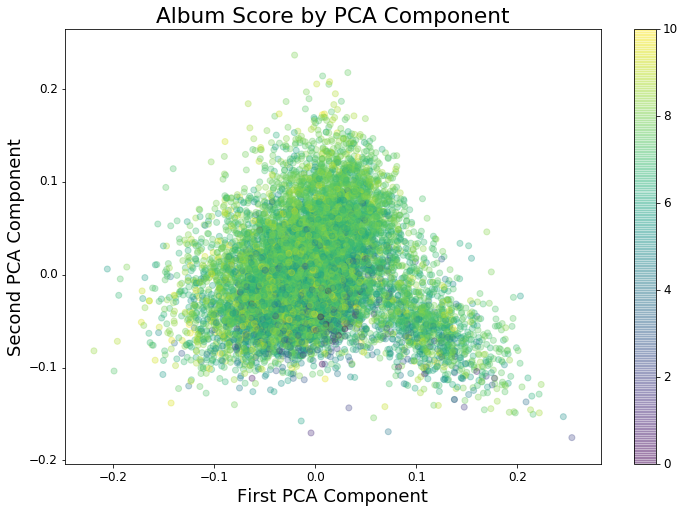

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

for genre in ['rap', 'rock', 'electronic']:
    genre_selector = targets_train['genre'] == genre
    ax.scatter(pca_features[:, 0][genre_selector],
               pca_features[:, 1][genre_selector], alpha=0.3, label=genre)

ax.legend(title="Genre")
ax.set_title("Genres by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.savefig('genres_by_pca.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sc = ax.scatter(pca_features[:, 0], pca_features[:, 1],
                alpha=0.3, c=targets_train['score'], cmap='viridis')
ax.set_title("Album Score by PCA Component")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.colorbar(sc)
plt.savefig('score_by_pca.png')

### Confusion Matrix for SVM/LVC
As suggested above, this classifier does a decent job on determining rap from non-rap, but otherwise has a bias towards classifying everythin which is not rap as rock.

Training Accuracy: 0.6831913939937247
Test Accuracy: 0.6732992739983866

Training f1: [0.78891778 0.63882163 0.26162791 0.84542587 0.03613369]
Test f1: [0.77974315 0.6199175  0.24954128 0.84180791 0.0166205 ]


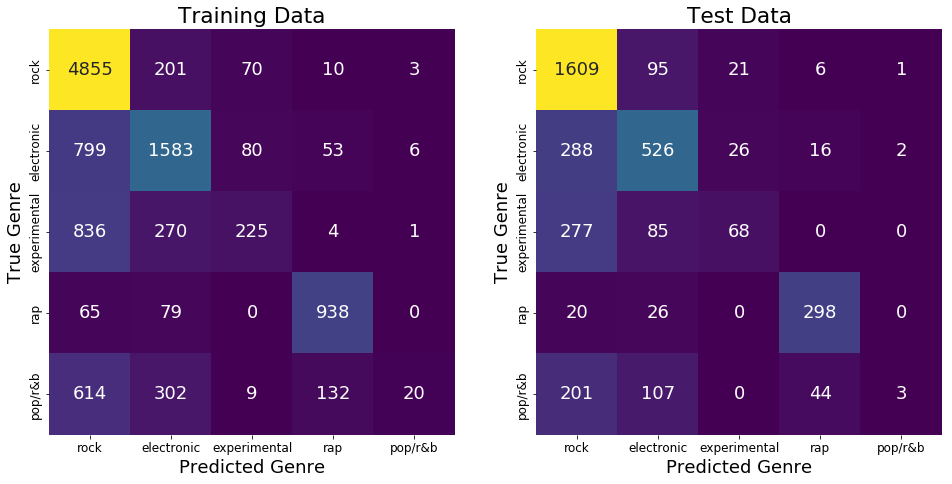

In [12]:
genre_labels = list(reversed(genre_order))

pred_train = clf_svm.predict(
    pca.transform(words_tfidf_train.toarray()))
pred_test = clf_svm.predict(
    pca.transform(words_tfidf_test.toarray()))

print('Training Accuracy: {}'.format(
    accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(
    accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(
    f1_score(targets_train['genre'], pred_train,
             average=None, labels=genre_labels)))
print('Test f1: {}'.format(
    f1_score(targets_test['genre'], pred_test,
             average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'],
                                  pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'],
                                 pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax=axs[0], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax=axs[1], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_svm.png')

## Data Modeling: Predicting Genre From Text Features With Naive Bayes

### Classify Genre with Naive Bayes

In [13]:
clf_nb = BernoulliNB()
clf_nb.fit(words_count_train, targets_train['genre'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Model Evaluation: Predicting Genre From Text Features With Naive Bayes

### Confusion Matrix using Naive Bayes

The classifier is still best at seperating rap from non-rap, but the distinction among the non-rap genres is much more well established.

Training Accuracy: 0.8218735992828328
Test Accuracy: 0.7023393385318634

Training f1: [0.87117614 0.78503937 0.75892207 0.89145497 0.6491913 ]
Test f1: [0.8003337  0.6536531  0.53125    0.82285714 0.30174081]


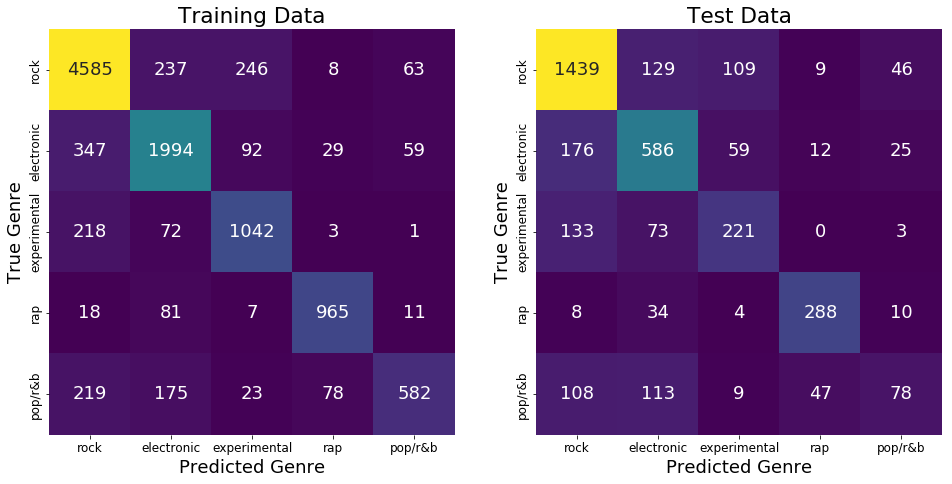

In [14]:
genre_labels = list(reversed(genre_order))

pred_train = clf_nb.predict(words_count_train.toarray())
pred_test = clf_nb.predict(words_count_test.toarray())

print('Training Accuracy: {}'.format(
    accuracy_score(targets_train['genre'], pred_train)))
print('Test Accuracy: {}'.format(
    accuracy_score(targets_test['genre'], pred_test)))
print('')
print('Training f1: {}'.format(
    f1_score(targets_train['genre'], pred_train,
             average=None, labels=genre_labels)))
print('Test f1: {}'.format(
    f1_score(targets_test['genre'], pred_test,
             average=None, labels=genre_labels)))

conf_mat_train = confusion_matrix(targets_train['genre'],
                                  pred_train, genre_labels)
conf_mat_test = confusion_matrix(targets_test['genre'],
                                 pred_test, genre_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(conf_mat_train, ax=axs[0], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[0].set_title('Training Data')
axs[0].set_xlabel('Predicted Genre')
axs[0].set_ylabel('True Genre')

sns.heatmap(conf_mat_test, ax=axs[1], annot=True, square=True,
            cmap='viridis', cbar=False, fmt="d",
            xticklabels=genre_labels, yticklabels=genre_labels)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Predicted Genre')
axs[1].set_ylabel('True Genre')

plt.savefig('class_nb.png')

## Data Modeling: Detecting Important Words Using LASSO

### Predicting important words for score using Lasso

Here, Lasso is used not only to try to predict album score from the review text, but to identify a compressed set of words with a strong influence on score. The tfidf vectors are cast to float32s so that my machine doesn't run out of memory and crash. Still, it tends to lock up my machine for a few seconds when it is run. We then use the memorizing stemmer to see what english words these features correspond to.

In [ ]:
reg = LassoLarsCV(cv=5, n_jobs=8)

reg.fit(words_tfidf_train.astype('float32').toarray(),
        targets_train['score'])

## Model Evaluation: Detecting Important Words Using LASSO

The blog post I wrote (see the link in the README) has a much larger discussion of the terms found, but we can see here that many of the words with negative correlations have negative connotations, and many of the most positively correlated words also have positive connotations. Thus, it seems plausible we have found a compressed set of words which most accuratly predict the score.

In [26]:
pred_train = reg.predict(words_tfidf_train)
pred_test = reg.predict(words_tfidf_test)
print("Train Score: {}".format(
    r2_score(targets_train['score'], pred_train)))
print("Test Score: {}".format(
    r2_score(targets_test['score'], pred_test)))

coef = reg.coef_
terms = vect_tfidf.inverse_transform(coef)

term_df = pd.DataFrame({
    'term': terms[0],
    'coef': coef[np.abs(coef) > 0]
}).sort_values('coef')

term_df['unstemmed'] = term_df['term'].apply(
    stemmer.unstem_most_common)

Train Score: 0.3607860867733067
Test Score: 0.2823405536169904


In [27]:
print("Number of regressors: {}".format(term_df.shape[0]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(term_df.sort_values('coef'))
term_df.to_csv("terms_from_lasso.csv")

Number of regressors: 352
                term       coef         unstemmed
160          insipid -10.996981           insipid
327         unlisten -10.443879      unlistenable
35             bland  -9.786086             bland
323         unfortun  -9.674447     Unfortunately
347             wors  -9.534159             worse
316        travistan  -8.122936         Travistan
187               m2  -7.254521                M2
72            decent  -6.930387            decent
252          problem  -6.920166           problem
86             dreck  -6.819590             dreck
121             frat  -6.549007              frat
319           turgid  -6.403541            turgid
64             cosmo  -6.319101             Cosmo
91            duritz  -6.187328            Duritz
22         audioslav  -6.095916        Audioslave
197          mediocr  -6.083906          mediocre
126          generic  -6.071394           generic
232          passabl  -5.718697          passable
346          woodwat  -5

### PCA on the compressed features

Here we use PCA to see if we can construct some features which have some stronger correlation with album score. Perhaps there is, but I was not able to do better predicting score with these features than with the Lasso regression above.

In [28]:
score_selector = SelectFromModel(reg, prefit=True)
score_words_train = score_selector.transform(words_tfidf_train)
score_words_test = score_selector.transform(words_tfidf_test)

score_pca = PCA(n_components=10)
score_pca_features_train = score_pca.fit_transform(score_words_train.toarray())
score_pca_features_test = score_pca.transform(score_words_test.toarray())

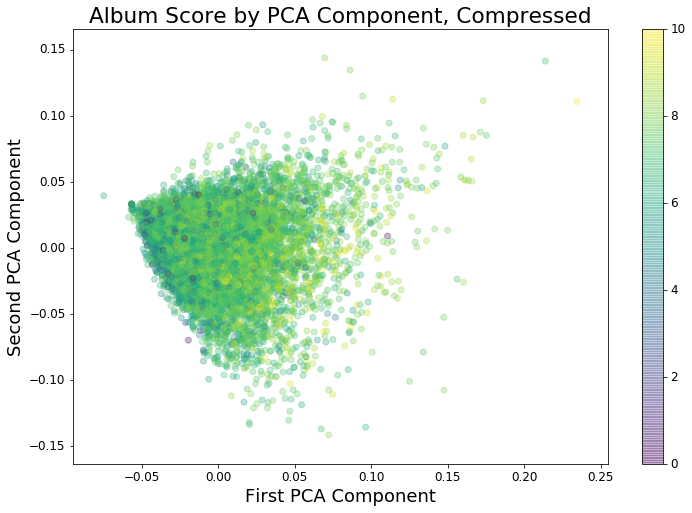

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
sc = ax.scatter(score_pca_features_train[:, 0], score_pca_features_train[:, 1],
                alpha=0.3, c=targets_train['score'], cmap='viridis')
ax.set_title("Album Score by PCA Component, Compressed")
ax.set_xlabel("First PCA Component")
ax.set_ylabel("Second PCA Component")
plt.colorbar(sc)
plt.savefig('compressed_score_by_pca.png')

### Find reviews with a particular term, for reference.

In [30]:
def find_term(df, t):
    "Select entries from our data that contain a particular stem."
    select = df['content_stemmed'].str.contains(t)
    return df[select]


test_df = find_term(df, 'travistan')

print(test_df)

       reviewid               title                        artist  score  \
2864       5607           travistan               travis morrison    0.0   
5867      10561           all y'all  travis morrison hellfighters    4.5   
7386      12544  the effects of 333   black rebel motorcycle club    0.4   
10954     16925     sod in the seed                          why?    5.2   
11092     17136         mumps, etc.                          why?    2.8   

       best_new_music        author    pub_date  \
2864                0  chris dahlen  2004-09-27   
5867                0   jason crock  2007-08-24   
7386                0     ian cohen  2009-01-06   
10954               0     ian cohen  2012-08-08   
11092               0     ian cohen  2012-10-09   

                                                 content       genre  \
2864   Travis Morrison got his ass kicked.  He tells ...     pop/r&b   
5867   \r\n    Some 2007 records I was cautiously\r\n...        rock   
7386   Credit where 

## Data Modeling: Looking for the 'Sophomore Slump'

Conventional wisdom holds that many bands tend to drop in quality on their second album vs. their first. Here we use the data to see if there is any evidence for this. First, a new data frame is constructed cointaining bands which have three or more releases.

In [12]:
select_artist = df.groupby('artist').count()['reviewid'] >= 3

scores_df = pd.DataFrame({
    'first_album': df.sort_values('pub_date').groupby('artist')
                     .first()[select_artist]['score'],
    'second_album': df.sort_values('pub_date').groupby('artist')
                     .nth(1)[select_artist]['score'],
    'third_album': df.sort_values('pub_date').groupby('artist')
                     .nth(2)[select_artist]['score'],
})

<ipython-input-12-7e400dbd1c9e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'second_album': df.sort_values('pub_date').groupby('artist')
<ipython-input-12-7e400dbd1c9e>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'third_album': df.sort_values('pub_date').groupby('artist')


## Model Evaluation: Looking for the 'Sophomore Slump'

The distribution of scores is plotted below, with the mean score. Some jitter is added to deal with quantization in the scores. Second albums have a lower mean than first albums, but is it significantly lower?

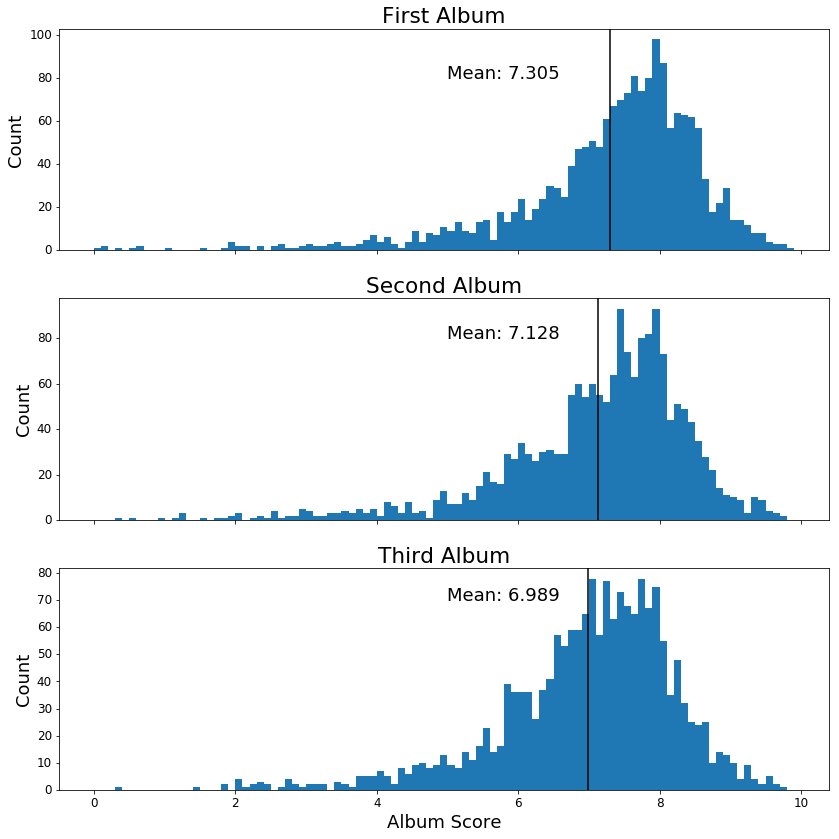

In [13]:
jitter = (np.random.rand(*scores_df.first_album.shape)-.5)/50

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

bins = np.arange(0, 10, 0.1)
axs[0].hist(scores_df['first_album']+jitter, bins=bins)
first_mean = scores_df['first_album'].mean()
axs[0].axvline(first_mean, c='k')
axs[0].set_title('First Album')
axs[0].set_ylabel('Count')
axs[0].annotate('Mean: {:.3f}'.format(first_mean), (5.0, 80))

axs[1].hist(scores_df['second_album']+jitter, bins=bins)
second_mean = scores_df['second_album'].mean()
axs[1].axvline(scores_df['second_album'].mean(), c='k')
axs[1].set_title('Second Album')
axs[1].set_ylabel('Count')
axs[1].annotate('Mean: {:.3f}'.format(second_mean), (5.0, 80))

axs[2].hist(scores_df['third_album']+jitter, bins=bins)
third_mean = scores_df['third_album'].mean()
axs[2].axvline(scores_df['third_album'].mean(), c='k')
axs[2].set_title('Third Album')
axs[2].set_xlabel('Album Score')
axs[2].set_ylabel('Count')
axs[2].annotate('Mean: {:.3f}'.format(third_mean), (5.0, 70))

plt.tight_layout()
plt.savefig('score_dist.png')

A t-test is used to determine if the distributions have different means. Based on the test, it does appear that the second score really is lower than the first on the whole. The third score is lower still, however the trend is not quite as strong.

In [14]:
print(scores_df['first_album'].mean())
print(scores_df['second_album'].mean())
print(scores_df['third_album'].mean())

print(scipy.stats.ttest_ind(scores_df['first_album'],
                            scores_df['second_album']))
print(scipy.stats.ttest_ind(scores_df['second_album'],
                            scores_df['third_album']))

7.305423353624794
7.128278915329275
6.989097952407304
Ttest_indResult(statistic=3.907604929073968, pvalue=9.49234930457459e-05)
Ttest_indResult(statistic=3.1958868854167326, pvalue=0.001406031124730276)


In [53]:
1/9.5e-5

10526.315789473683

In [54]:
1/0.0014

714.2857142857143